# Optimizing Softmax Regression with MCMC

In this project we implemented a parameter optimizing method based on the Bayesian inference with Markov chain Monte Carlo (MCMC) to optimize the parameters of a Softmax Regression model. We investigated the performance of our method on two multi-class classification tasks. We also compared the performance of this method to the performance of optimizing the same model with Gradient Descent.

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import emcee
import corner

## Softmax Regression

We define the Softmax Regression class first. As the generalization of Logistic Regression, Softmax Regression is essentially a linear model wrapped by a softmax function that calculates the probabilities for label classes for multi-class classification tasks.

To train or fit a Softmax Regression model with a training dataset, we need to input an optimizer object for optimizing the parameters of the model. There are two types of optimizer. The first type of optimizer is based on Bayesian inference with Markov chain Monte Carlo (MCMC), which is also the type of optimizer of our main interests. This type of optimizer can infer the distributions of the parameters and thus can calculate the error bars (credible intervals) of the reuslt probabilities. The second type of optimizer is based on Gradient Descent. This type of optimizer is the most popular one for machine learning models and thus is a good reference for the performance of our MCMC optimizer. These two types of optimizer will be implemented later.

Part of the code in this section is adopted from the Softmax Regression implementation in this project: [GitHub page](https://github.com/Foo2000/Multi-Class-Logistic-Regression-and-Gradient-Descent).

In [2]:
# define the functions that will be used in the Softmax Regression class

def softmax(z):                                        # define the softmax function
            z -= np.max(z)                             # for numerical stability
            return (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
        
def softmax_chain(z):                                  # define the softmax function for a whole MCMC chain (for error bar calculation later)
            z -= np.max(z)                             # for numerical stability
            return (np.exp(z) / (np.repeat(np.sum(np.exp(z),axis=2), z.shape[2]).reshape(z.shape[0],z.shape[1],z.shape[2])))
    
def one_hot(y, C):                                     # define the one-hot encoding for labels
            return (np.arange(C) == y[:, None]).astype(float)



# define the Softmax Regression class

class SoftmaxRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias                       # check whether it is needed to add a constant term (bias) to the linear model inside
    
    def fit(self, x, y, optimizer):                    # define the function for training the model with a training dataset and an optimizer
        if self.add_bias:                              # add a bias term to x if it is required
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        C = np.max(y) + 1                              # C is the number of classes of y
        w0 = np.zeros((D, C))                          # initialize the weights (i.e. parameters) to 0, note that the dimension is D*C
        
        # if the optimizer is a BayesianInferenceMCMC object, optimize using MCMC
        if isinstance(optimizer, BayesianInferenceMCMC):
            def log_likelihood(w_flat, x, y):
                w_og = w_flat.reshape(x.shape[1],np.max(y)+1) # reshape the flattened 1d parameter array into the origianl dimension
                yh = softmax(np.dot(x, w_og))               # predictions, i.e. the probabilities for each label class
                y = one_hot(y, C)                           # labels with one-hot encoding
                log_like = np.sum(y*np.log(yh))             # log corss-entropy likelihood
                # MCMC introduces random parameters, which can be very large
                # some large parameters may cause the softmax function to overflow and return nan
                # in fact these large parameters are definitely not good parameters for the model
                # so we treat these cases as zero likelihood, i.e. -infinity log likelihood
                if math.isnan(log_like):
                    return -np.inf
                return log_like
            def log_prior(w_flat):
                return 0.0                                  # no specific preference for the parameters
            def log_post(w_flat, x, y):
                return log_prior(w_flat) + log_likelihood(w_flat, x, y)
            self.w = optimizer.run(log_post, x, y, w0)      # run the optimizer to get [optimal weights, whole chain]
            
        # if the optimizer is a ImprovedGradientDescent object, optimize using Gradient Descent
        if isinstance(optimizer, ImprovedGradientDescent):
            def gradient(x, y, w):                          # define the gradient function
                yh = softmax(np.dot(x, w))                  # predictions
                y = one_hot(y, C)                           # labels with one-hot encoding
                N, D = x.shape
                grad = np.dot(x.T, (yh - y))/N              # divide by N because cost is mean over N points
                return grad
            self.w = [optimizer.run(gradient, x, y, w0)]    # run the optimizer to get [optimal weights]
            
        return self
    
    def predict(self, x, err=0):
        # pridict without error bars (optimizers of both types can do this)
        if err==0:
            if x.ndim == 1:
                x = x[:, None]
            if self.add_bias:
                N = x.shape[0]
                x = np.column_stack([x,np.ones(N)])
            yh = softmax(np.dot(x,self.w[0]))                 # predict a single output with a single set of parameters
            return yh
        
        # want to pridict with error bars but did not use a MCMC optimizer before
        # raise an error, since only MCMC optimizers can provide the uncertainty information using the whole chain
        elif len(self.w)==1:
            print("Optimizer needs to be BayesianInferenceMCMC if error bars are required")
        
        # pridict with error bars (use the whole chain provided by the MCMC optimizer to calculate credible intervals)
        else:
            if x.ndim == 1:
                x = x[:, None]
            if self.add_bias:
                N = x.shape[0]
                x = np.column_stack([x,np.ones(N)])
            yh_dist = softmax_chain(np.dot(x,self.w[1]))      # predict the output distribution with all sets of parameters in the MCMC chain
            yh = np.nanmedian(yh_dist, axis=1)                # pick the median to be the final output
            # get the error bar array
            error_bar = np.array([np.nanpercentile(yh_dist, (100-err),axis=1), np.nanpercentile(yh_dist, err,axis=1)]).T
            # adjust the shape of the error bar array
            num_d, num_c = yh.shape
            err_colums = np.linspace(0,len(error_bar)-1,len(error_bar)).astype(int)
            error_bar = np.column_stack(error_bar[err_colums]).reshape(num_d, num_c,2)
            # note that the outpuut is of format [pridictions, error bars] in this case
            return [yh,error_bar]

In [3]:
# note that the output of the Softmax Regression is the probabilities for the label classes
# so we need to convert the output into the label classes with the highest probabilities for the classification purpose

def to_classlabel(z):                                   # convert the output class probabilities to be class labels
    return z.argmax(axis=1)

## Optimizer 1: Bayesian inference with MCMC

We define the class of optimizer that is based on Bayesian inference with Markov chain Monte Carlo. This type of optimizer takes optimally a chain of samples of parameters with MCMC steps based on the corresponding log-likelihoods to infer the distributions of the parameters. Based on the result distributions, we can take the median of the samples of parameters to be the optimal parameters to return. We also return the whole chain so that we can calculate the error bars (credible intervals) of the parameters thus the error bars of the reuslt probabilities if needed later.

We also added two visualization options. The first option is for visualizing the log-likelihoods along the sample chain. The second option is for visualizing the distributions of the parameters using corner plot.

In [4]:
class BayesianInferenceMCMC:
    def __init__(self, visual_log_like=False, corner=False):
        self.visual_log_like = visual_log_like
        self.corner = corner
            
    def run(self, log_post, x, y, w):
        num_iter = 4000
        w_flat = w.reshape(-1) # reshape the parameter array into a 1d array that can be input of emcee
        ndim = len(w_flat)     # number of parameters
        nwalkers = 60
        initial_pos = w_flat + 0.01 * np.random.randn(nwalkers, ndim)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x, y))
        sampler.run_mcmc(initial_pos, num_iter, progress=True)
        w_flat = np.median(sampler.get_chain(discard=2000, flat=True), axis=0)
        w = w_flat.reshape(x.shape[1],np.max(y) + 1) # reshape the optimized 1d parameter array into the origianl dimension
        whole_chain = sampler.get_chain(discard=2000, flat=True).reshape(2000*60, x.shape[1], np.max(y) + 1)
        
        # visualize the log-likelihood evolved with the MCMC steps if needed
        if self.visual_log_like == True:
            plt.plot(np.linspace(0,num_iter,num_iter), sampler.lnprobability.T)
            plt.title('log-likelihood v.s. steps')
            plt.xlabel("Steps")
            plt.ylabel("log-likelihood")
            plt.show()
        
        # plot the corner plot if needed
        if self.corner == True:
            flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
            fig = corner.corner(flat_samples, quantiles=[0.05, 0.5, 0.95])
        
        return [w, whole_chain]

## Optimizer 2: Gradient Descent (for comparison)

We define the class of optimizer that is based on Gradient Descent. This is a mini-batch gradient descent optimizer with momentum. The learning_rate, momentum, and batch_size are adjustable hyperparameters.

This section is adopted from the Improved Gradient Descent implementation in this project: [GitHub page](https://github.com/Foo2000/Multi-Class-Logistic-Regression-and-Gradient-Descent).

In [5]:
def create_mini_batches(x, y, batch_size): 
    mini_batches = []
    data = np.hstack((x, y[:,None]))
    np.random.shuffle(data) 
    n_minibatches = math.ceil(data.shape[0] // batch_size) 
    data = np.array_split(data, n_minibatches)
    mini_batches = []
    for batch_data in data:
        x_mini = batch_data[:, :-1]
        y_mini = batch_data[:, -1]
        mini_batches.append((x_mini, y_mini))
    return mini_batches

class ImprovedGradientDescent:
    def __init__(self, learning_rate=0.1, max_iters=1e4, epsilon=1e-8, record_history=False, momentum=0.5, batch_size=20):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.momentum = momentum
        self.batch_size = batch_size
        if record_history:
            self.w_history = []                         #to store the weight history for visualization
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        grad_old = 0
        t = 1
        accuracy = 0
        accuracy_best = 0
        num_worse = 0
        w_best = w
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            mini_batches = create_mini_batches(x, y, self.batch_size) 
            for mini_batch in mini_batches: 
                x_mini, y_mini = mini_batch
                grad = self.momentum*grad_old + (1-self.momentum)*gradient_fn(x_mini, y_mini, w)  # compute the gradient with present weight and momentum
                w = w - self.learning_rate * grad       # weight update step
                grad_old = grad                         # the current gradient is the old gradient for the next iteration
            if self.record_history:
                self.w_history.append(w)
            accuracy = (to_classlabel(softmax(np.dot(x, w))) == y).astype(float).mean()
            if accuracy > accuracy_best:
                num_worse = 0
                accuracy_best = accuracy
                w_best = w
            else:
                num_worse += 1
            if num_worse >= 20:
                break
            t += 1
        w = w_best
        return w

## Performance Analysis 1: Iris dataset

Test the performance of the Softmax Regression model with the two types of optimizer on the classical Iris dataset. Our model classifies the species of Iris based on the input features.

In [6]:
from sklearn import datasets
import time

In [7]:
# load the dataset and split it into train and test sets

iris = datasets.load_iris()

iris_data = np.hstack((iris['data'],iris['target'][:,None]))
np.random.shuffle(iris_data)

train = iris_data[:(len(iris_data)*3//4)]
train_x = train[:,:-1]
train_y = train[:,-1].astype(int)

test = iris_data[(len(iris_data)*3//4):]
test_x = test[:,:-1]
test_y = test[:,-1].astype(int)

In [8]:
# fit the Softmax Regression model based on the train set using Gradient Descent, and predict the test set

start = time.time()
regressor_iris_GD = SoftmaxRegression().fit(train_x,train_y, 
                                            ImprovedGradientDescent(learning_rate=0.01,momentum=0.9, batch_size=1))
stop = time.time()
train_time = stop - start
test_yh = regressor_iris_GD.predict(test_x)
test_accuracy = (to_classlabel(test_yh) == test_y).astype(float).mean()
print("The training time is", train_time)
print("The test accuracy is", test_accuracy)

The training time is 0.12549090385437012
The test accuracy is 0.9736842105263158


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:15<00:00, 264.84it/s]


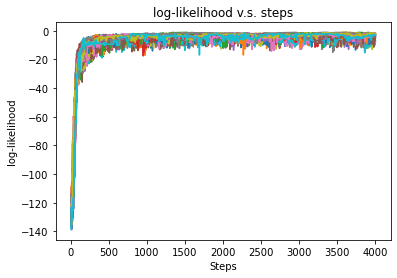

The training time is 20.203278303146362
The test accuracy is 0.9736842105263158


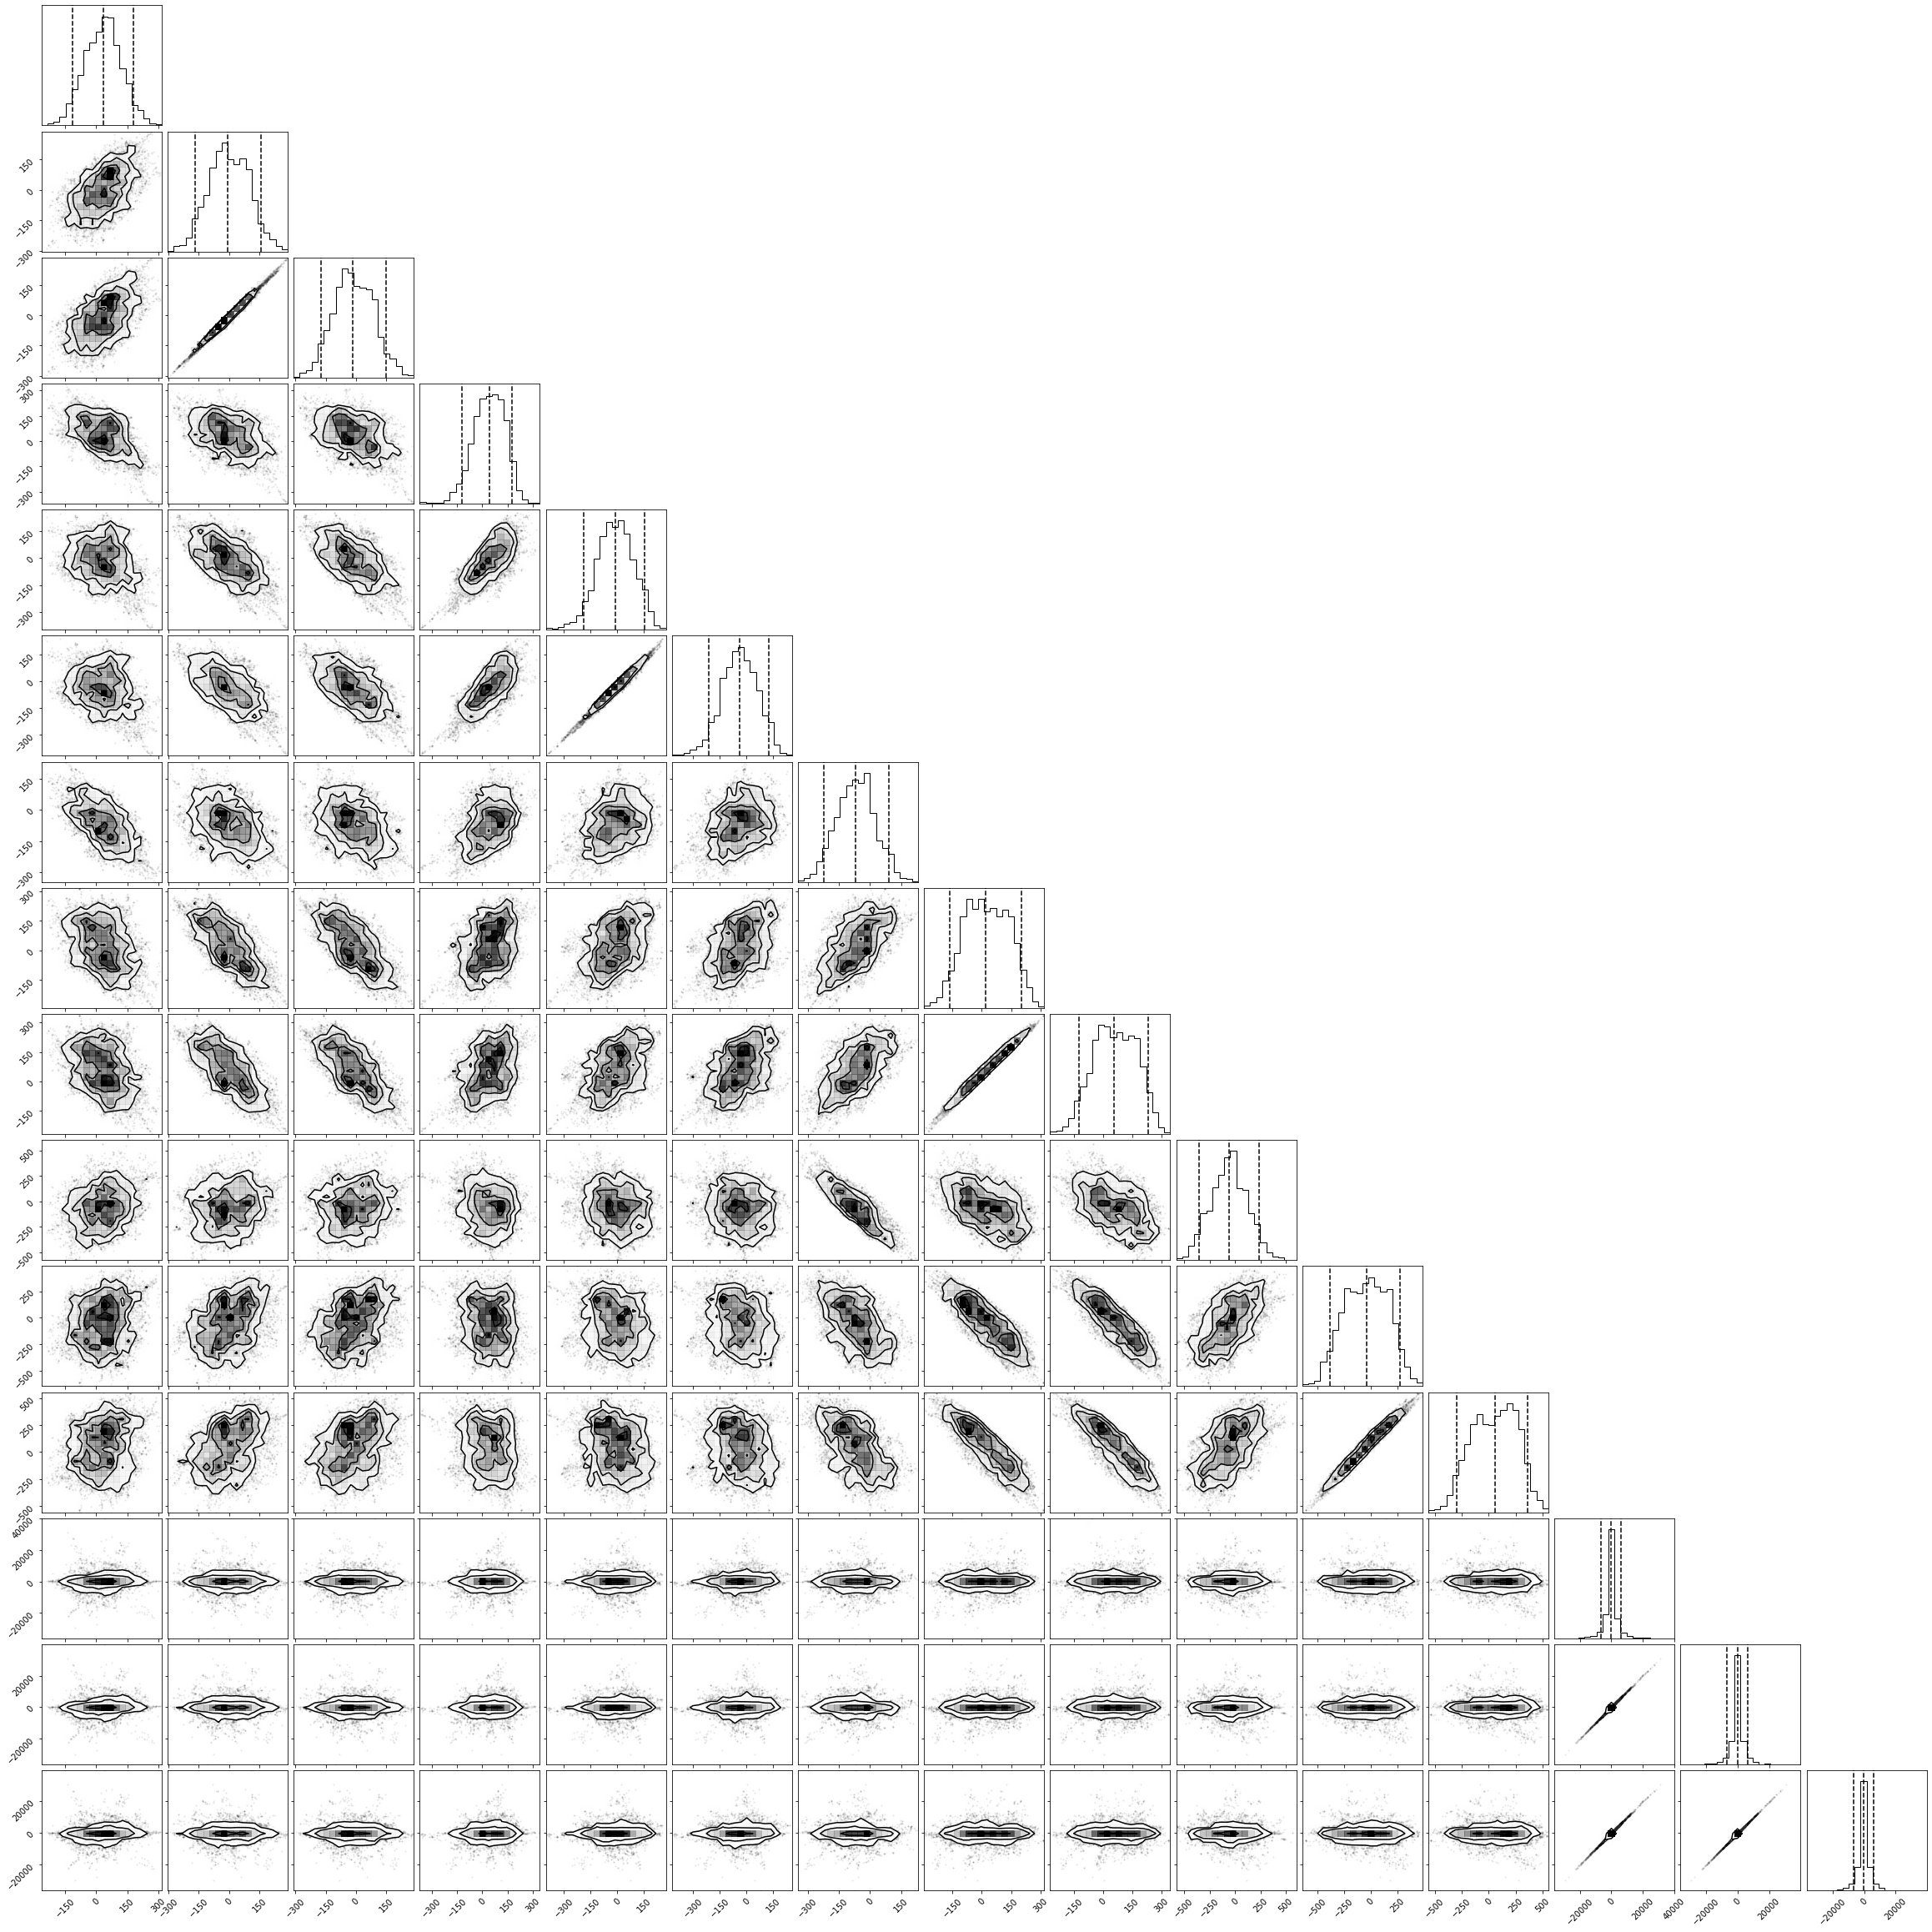

In [9]:
# fit the Softmax Regression model based on the train set using MCMC, and predict the test set
# we present all visualizations for the training process here

start = time.time()
regressor_iris_MC = SoftmaxRegression().fit(train_x,train_y, 
                                            BayesianInferenceMCMC(visual_log_like=True, corner=True))
stop = time.time()
train_time = stop - start
# pridict the test data with 95% credible intervals (error bars)
# note that the results yh is of format [pridictions, error bars]
test_yh = regressor_iris_MC.predict(test_x, err=95)
test_accuracy = (to_classlabel(test_yh[0]) == test_y).astype(float).mean()
print("The training time is", train_time)
print("The test accuracy is", test_accuracy)

The pridicted probabilities for the first test data:
[4.55332059e-31 1.00000000e+00 7.80000697e-39]
The 95% credible intervals for these probabilities:
[[4.55332059e-31 4.55332059e-31]
 [1.00000000e+00 1.00000000e+00]
 [7.80000697e-39 7.80000697e-39]]


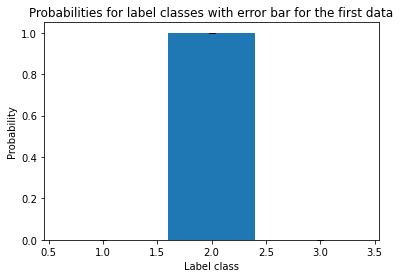

In [10]:
# show the first pridiction data point for visualization

print("The pridicted probabilities for the first test data:")
print(test_yh[0][0])
print("The 95% credible intervals for these probabilities:")
print(test_yh[1][0])


plt.bar([1,2,3],test_yh[0][1],yerr=(test_yh[0][1]-test_yh[1][1].T[0]),capsize=3)
plt.title('Probabilities for label classes with error bar for the first data')
plt.xlabel('Label class')
plt.ylabel('Probability')
plt.show()

## Performance Analysis 2: SDSS dataset

Test the performance of the Softmax Regression model with the two types of optimizer on the noisy SDSS dataset. Our model classifies the type of astronomical object based on the input features.

In [11]:
# load the dataset, preprocess it, and split it into train and test sets

# read the raw SDSS dataset
SDSS = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv')
# drop the irrelevant data:
SDSS.drop(['objid', 'rerun', 'specobjid', 'plate'], axis=1, inplace=True)
# drop the correlated data:
SDSS.drop(['g', 'r', 'i', 'mjd'], axis=1, inplace=True)
# rearrange the columns
SDSS = SDSS[['ra', 'dec', 'u', 'z', 'run', 'camcol', 'field', 'redshift', 'fiberid', 'class']]
# scale the dataset
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler().fit(SDSS[['ra', 'dec', 'u', 'z', 'run', 'camcol', 'field', 'redshift', 'fiberid']])
scaled_x = scale.transform(SDSS[['ra', 'dec', 'u', 'z', 'run', 'camcol', 'field', 'redshift', 'fiberid']])
SDSS = np.column_stack([scaled_x,SDSS['class']])
SDSS = pd.DataFrame(SDSS, columns=['ra', 'dec', 'u', 'z', 'run', 'camcol', 'field', 'redshift', 'fiberid', 'class'])
# convert the labels to 0,1,2 for easy one-hot encoding
SDSS['class'] = SDSS['class'].replace(['STAR'], 0)
SDSS['class'] = SDSS['class'].replace(['GALAXY'], 1)
SDSS['class'] = SDSS['class'].replace(['QSO'], 2)
# convert the pd dataframe into a np array for use
SDSS_data = SDSS.values.astype(float)

train = SDSS_data[:(len(SDSS_data)*3//4)]
train_x = train[:,:-1]
train_y = train[:,-1].astype(int)

test = SDSS_data[(len(SDSS_data)*3//4):]
test_x = test[:,:-1]
test_y = test[:,-1].astype(int)

In [12]:
# fit the Softmax Regression model based on the train set using Gradient Descent, and predict the test set

start = time.time()
regressor_SDSS_GD = SoftmaxRegression().fit(train_x,train_y, 
                                            ImprovedGradientDescent(learning_rate=0.01,momentum=0.9, batch_size=4))
stop = time.time()
train_time = stop - start
test_yh = regressor_SDSS_GD.predict(test_x)
test_accuracy = (to_classlabel(test_yh) == test_y).astype(float).mean()
print("The training time is", train_time)
print("The test accuracy is", test_accuracy)

The training time is 98.84665775299072
The test accuracy is 0.8312


In [13]:
# fit the Softmax Regression model based on the train set using MCMC, and predict the test set
# we fit the model with the default setting here, i.e. no visualization

start = time.time()
regressor_SDSS_MC = SoftmaxRegression().fit(train_x,train_y, 
                                            BayesianInferenceMCMC())
stop = time.time()
train_time = stop - start
# pridict the test data with 95% credible intervals (error bars)
# note that the results yh is of format [pridictions, error bars]
# note that error bars requires a huge amount time and space to calculate here, since the dimension and size of this SDSS dataset is large
test_yh = regressor_SDSS_MC.predict(test_x, err=95)
test_accuracy = (to_classlabel(test_yh[0]) == test_y).astype(float).mean()
print("The training time is", train_time)
print("The test accuracy is", test_accuracy)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [04:16<00:00, 15.62it/s]


The training time is 256.1935329437256
The test accuracy is 0.9128


The pridicted probabilities for the first test data:
[8.36545607e-01 1.63410080e-01 2.44081306e-06]
The 95% credible intervals for these probabilities:
[[7.73868146e-01 8.88452774e-01]
 [1.11546483e-01 2.26130731e-01]
 [1.49819374e-07 8.80187244e-05]]


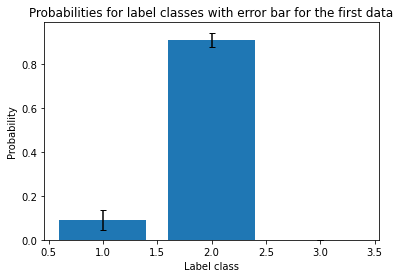

In [14]:
# show the first pridiction data point for visualization

print("The pridicted probabilities for the first test data:")
print(test_yh[0][0])
print("The 95% credible intervals for these probabilities:")
print(test_yh[1][0])


plt.bar([1,2,3],test_yh[0][1],yerr=(test_yh[0][1]-test_yh[1][1].T[0]),capsize=3)
plt.title('Probabilities for label classes with error bar for the first data')
plt.xlabel('Label class')
plt.ylabel('Probability')
plt.show()